In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in python modules
import time
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd

# Sandia pvlib-python
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../')
import src

# 1. Synthetic data for one month

In [2]:
FILE = ['bogota-5', 'bogota-30', 'bogota-60']

df = {}
for i in FILE:
    df[i] = pd.read_csv(filepath_or_buffer=f'./data/{i}.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True).fillna(0)

In [3]:
IC = 0.95

LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']
RUNS = [10, 50, 100, 500, 1000]

ETS = pd.DataFrame(index=RUNS, columns=FILE)
ETB = pd.DataFrame(index=RUNS, columns=FILE)

for n, i in enumerate(FILE):
    RESOLUTION = int(pd.Series(df[i].index.values).diff().median().total_seconds()/60)

    YEAR = df[i].index.year.unique()[-1]
    MONTH = df[i].index.month.unique()[0]

    # Clear-sky irradiance (Hcs)
    location = pvlib.location.Location(latitude=4.6024, longitude=-74.0674, tz='America/Bogota', altitude=2624)

    hcs = location.get_clearsky(times=pd.date_range(start=df[i].index[0],end=df[i].index[-1], freq=f'{RESOLUTION}min', tz='America/Bogota'), model='ineichen')

    df[i]['hcs_wm2'] = hcs['ghi'].values
    df[i]['kc'] = df[i]['ghi_wm2'].values / df[i]['hcs_wm2'].values
    df[i]['kc'] = df[i]['kc'].fillna(1)
    df[i].loc[df[i]['kc'] > 1, 'kc'] = 1

    # Stochastic
    elapsed_time = []
    for j in RUNS:
        start = time.time()

        for k in LOOP_SC:
            _ = src.methods.sequential(data=df[i],
                                       irradiance_column='ghi_wm2',
                                       year=YEAR,
                                       month=MONTH,
                                       sky_condition=k,
                                       method='stochastic',
                                       IC=IC,
                                       resolution=RESOLUTION,
                                       runs=j)

        end = time.time()

        elapsed_time.append(end - start)

    ETS[i] = elapsed_time

    # Bootstrap
    elapsed_time = []
    for j in RUNS:
        start = time.time()

        for k in LOOP_SC:
            _ = src.methods.sequential(data=df[i],
                                       irradiance_column='ghi_wm2',
                                       year=YEAR,
                                       month=MONTH,
                                       sky_condition=k,
                                       method='bootstrap',
                                       IC=IC,
                                       resolution=RESOLUTION,
                                       runs=j)

        end = time.time()

        elapsed_time.append(end - start)

    ETB[i] = elapsed_time

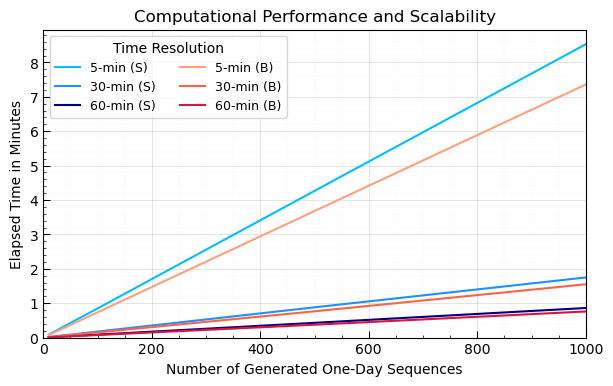

In [27]:
hor = 7
ver = 4
plt.figure(figsize=(hor,ver), dpi=100)

plt.plot(ETS['bogota-5']/60, color='deepskyblue', label='5-min (S)')
plt.plot(ETS['bogota-30']/60, color='dodgerblue', label='30-min (S)')
plt.plot(ETS['bogota-60']/60, color='navy', label='60-min (S)')

plt.plot(ETB['bogota-5']/60, color='lightsalmon', label='5-min (B)')
plt.plot(ETB['bogota-30']/60, color='tomato', label='30-min (B)')
plt.plot(ETB['bogota-60']/60, color='crimson', label='60-min (B)')

plt.title('Computational Performance and Scalability')
plt.ylabel('Elapsed Time in Minutes')
plt.xlabel('Number of Generated One-Day Sequences')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, 1000)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9, ncols=2, title='Time Resolution') # bbox_to_anchor=(1,1)
plt.savefig('../figs/fig19.pdf', dpi=300, bbox_inches='tight')